<a href="https://colab.research.google.com/github/n3rd0x/Udacity_IntroTensorFlowForDeepLearning/blob/master/010_Saving_and_Loading_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Education - Udacity "Intro to TensorFlow for Deep Learning"
# Module: Saving and Loading Models
# REF: https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l07c01_saving_and_loading_models.ipynb

In [2]:
# Import packages.
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import logging

# Using version 2.x of Tensorflow.
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Tensorflow.
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Set logging level.
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Print Tensorflow version.
print('TensorFlow Version:', tf.__version__)

TensorFlow 2.x selected.
TensorFlow Version: 2.1.0-rc1


In [3]:
# Setup dataset.
print('Download and split the dataset....')
splits = tfds.Split.ALL.subsplit(weighted = (80, 20))
(dataset_training, dataset_validation), dataset_info = tfds.load(
  'cats_vs_dogs',
  with_info = True,
  as_supervised = True,
  split = splits
)
print('Preparing completed.')

Download and split the dataset....


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.
Preparing completed.


In [4]:
# Display info.
num_classes   = dataset_info.features['label'].num_classes
num_examples  = dataset_info.splits['train'].num_examples

print('-- Total Summary --')
print('Total Classes:    {}'.format(num_classes))
print('Total Exmples:    {}'.format(num_examples))

-- Total Summary --
Total Classes:    2
Total Exmples:    23262


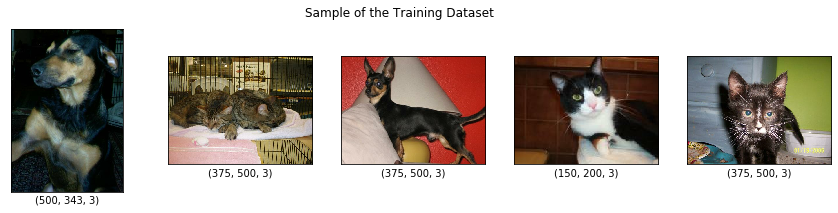

In [5]:
# Display some of the samples.
samples = dataset_training.take(5)
plt.figure(figsize = (15, 3))
for i, img in enumerate(samples):
  plt.subplot(1, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img[0])
  plt.xlabel(img[0].shape)
_ = plt.suptitle('Sample of the Training Dataset')

In [6]:
# MobileNet: 224 x 224 with RGB and normalize [0, 1]
BATCH_SIZE = 32
IMAGE_RES  = 224

print('Resize Process....')

def formatImage(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
  return image, label

batch_training    = dataset_training.shuffle(num_examples//4).map(formatImage).batch(BATCH_SIZE).prefetch(1)
batch_validation  = dataset_validation.map(formatImage).batch(BATCH_SIZE).prefetch(1)
print('Resize Completed.')

Resize Process....
Resize Completed.


In [7]:
# Build the model.
EPOCHS = 3
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
print('Total Epochs: {}'.format(EPOCHS))
print('--------------------------------------------')
print('-- MobileNet')
print('--------------------------------------------')
print('Create a feature extractor.')
print('URL: {}'.format(URL))

# Create the feature extractor.
# Freeze the extrator so we don't update its pretraing values.
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
feature_extractor.trainable = False
  
# Build our model to classify the flowers.
model = tf.keras.Sequential()
model.add(feature_extractor)
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.summary()

Total Epochs: 3
--------------------------------------------
-- MobileNet
--------------------------------------------
Create a feature extractor.
URL: https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
# Train the model.
# Loss Keyword: sparse_categorical_crossentropy
print('Compile the model.')
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)

print('Start training the model....')
history = model.fit(
  batch_training,
  epochs=EPOCHS,
  validation_data = batch_validation
)
print('--------------------------------------------')

Compile the model.
Start training the model....
Epoch 1/3
582/582 [==============================] - 53s 91ms/step - loss: 0.0597 - accuracy: 0.9789 - val_loss: 0.0323 - val_accuracy: 0.9866
Epoch 2/3
582/582 [==============================] - 43s 74ms/step - loss: 0.0303 - accuracy: 0.9905 - val_loss: 0.0381 - val_accuracy: 0.9862
Epoch 3/3
582/582 [==============================] - 43s 73ms/step - loss: 0.0263 - accuracy: 0.9913 - val_loss: 0.0292 - val_accuracy: 0.9897
--------------------------------------------


In [9]:
# Predict testing.
class_names = np.array(dataset_info.features['label'].names)

batch_image, batch_label = next(iter(batch_training.take(1)))
batch_image = batch_image.numpy()
batch_label = batch_label.numpy()

batch_predicted = model.predict(batch_image)
batch_predicted = tf.squeeze(batch_predicted).numpy()

predicted_ids     = np.argmax(batch_predicted, axis=-1)
predicted_classes = class_names[predicted_ids]

print('Predict testing.')
print('Class Names:       {}'.format(class_names))
print('Correct Labels:    {}'.format(batch_label))
print('Predicted IDs:     {}'.format(predicted_ids))
print('Predicted Classes: {}'.format(predicted_classes))

Predict testing.
Class Names:       ['cat' 'dog']
Correct Labels:    [1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 1]
Predicted IDs:     [1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 1]
Predicted Classes: ['dog' 'dog' 'cat' 'cat' 'dog' 'cat' 'cat' 'dog' 'dog' 'cat' 'dog' 'dog'
 'dog' 'dog' 'dog' 'dog' 'dog' 'dog' 'cat' 'cat' 'cat' 'cat' 'dog' 'dog'
 'dog' 'cat' 'cat' 'cat' 'dog' 'cat' 'cat' 'dog']


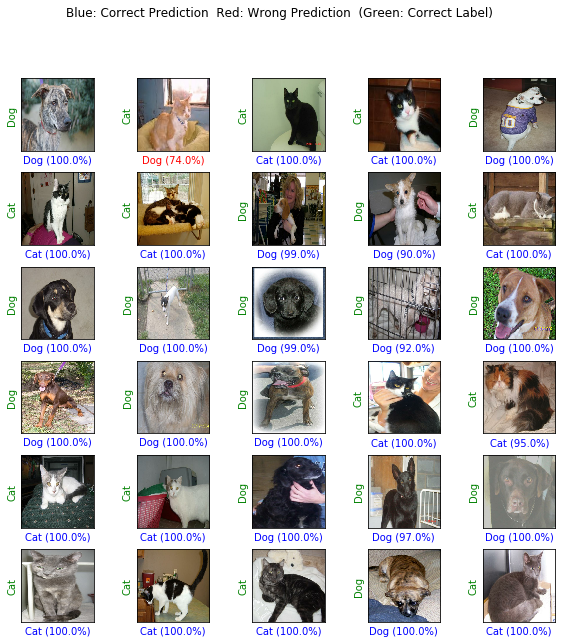

In [10]:
plt.figure(figsize=(10, 10))
for i in range(30):
  plt.subplot(6, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(batch_image[i])
  color = 'blue' if predicted_ids[i] == batch_label[i] else 'red'
  plt.xlabel('{} ({}%)'.format(predicted_classes[i].title(), round(100 * np.max(batch_predicted[i]))), color = color)
  plt.ylabel(class_names[batch_label[i]].title(), color = 'green')

_ = plt.suptitle("Blue: Correct Prediction  Red: Wrong Prediction  (Green: Correct Label)")

In [11]:
# Save as Keras model.
keras_file = './pretrained_model_keras.h5'
model.save(keras_file)
print('Save Keras model ({})'.format(keras_file))
!ls -lh

Save Keras model (./pretrained_model_keras.h5)
total 8.9M
-rw-r--r-- 1 root root 8.9M Jan  4 16:19 pretrained_model_keras.h5
drwxr-xr-x 1 root root 4.0K Dec 18 16:52 sample_data


In [12]:
# Load saved Keras model.
loaded_model = tf.keras.models.load_model(
  keras_file,
  # 'custom_object' tells Keras how to load a 'hub.KerasLayer'
  custom_objects = {'KerasLayer' : hub.KerasLayer}
)
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
# Compare the models.
original_batch  = model.predict(batch_image)
loaded_batch    = loaded_model.predict(batch_image)

res = (abs(original_batch - loaded_batch)).max()
print('Comparing Original vs Loaded: {}'.format(res))
print('Here we expect 0.0')
print('Zero means there are no different.')

Comparing Original vs Loaded: 0.0
Here we expect 0.0
Zero means there are no different.


In [14]:
# Keep training.
print('Continue traing our loaded model for improving accuracy.')
history = loaded_model.fit(
  batch_training,
  epochs=EPOCHS,
  validation_data = batch_validation
)
print('Training completed.')

Continue traing our loaded model for improving accuracy.
Epoch 1/3
582/582 [==============================] - 46s 79ms/step - loss: 0.0219 - accuracy: 0.9929 - val_loss: 0.0304 - val_accuracy: 0.9888
Epoch 2/3
582/582 [==============================] - 44s 75ms/step - loss: 0.0200 - accuracy: 0.9936 - val_loss: 0.0312 - val_accuracy: 0.9890
Epoch 3/3
582/582 [==============================] - 43s 73ms/step - loss: 0.0173 - accuracy: 0.9944 - val_loss: 0.0327 - val_accuracy: 0.9881
Training completed.


In [15]:
# Compare the models.
original_batch  = model.predict(batch_image)
loaded_batch    = loaded_model.predict(batch_image)

res = (abs(original_batch - loaded_batch)).max()
print('Comparing Original vs Loaded (after training): {}'.format(res))
print('Here we expect non-zero value.')
print('Zero means there are no different.')

Comparing Original vs Loaded (after training): 0.5343814492225647
Here we expect non-zero value.
Zero means there are no different.


In [16]:
# Export as TensorFlow SavedModel.
path_sm = './tensorflow_saved_model'
!rm -rf $path_sm/*
tf.saved_model.save(model, path_sm)
print('Save the model into {}.'.format(path_sm))
!ls -lh

print('----------------------')
print('-- {}'.format(path_sm))
print('----------------------')
!ls -lh {path_sm}
print('----------------------')

Save the model into ./tensorflow_saved_model.
total 8.9M
-rw-r--r-- 1 root root 8.9M Jan  4 16:19 pretrained_model_keras.h5
drwxr-xr-x 1 root root 4.0K Dec 18 16:52 sample_data
drwxr-xr-x 4 root root 4.0K Jan  4 16:22 tensorflow_saved_model
----------------------
-- ./tensorflow_saved_model
----------------------
total 2.2M
drwxr-xr-x 2 root root 4.0K Jan  4 16:22 assets
-rw-r--r-- 1 root root 2.2M Jan  4 16:22 saved_model.pb
drwxr-xr-x 2 root root 4.0K Jan  4 16:22 variables
----------------------


In [19]:
# Reload TensorFlow SavedModel.
saved_model = tf.saved_model.load(path_sm)

loaded_sm_batch = saved_model(batch_image, training=False).numpy()
res = (abs(original_batch - loaded_sm_batch)).max()
print('Comparing Original vs Loaded SavedModel: {}'.format(res))
print('Here we expect 0.0')
print('Zero means there are no different.')

Comparing Original vs Loaded SavedModel: 0.0
Here we expect 0.0
Zero means there are no different.


In [20]:
# Load SavedModel as Keras model for continue training, if wanted.
loaded_sm_keras = tf.keras.models.load_model(
  path_sm,
  custom_objects = {'KerasLayer': hub.KerasLayer}
)
loaded_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
# Comparing the prediction.
original_batch = model.predict(batch_image)
loaded_sm_batch = loaded_sm_keras.predict(batch_image)
res = (abs(original_batch - loaded_sm_batch)).max()
print('Comparing Original vs Loaded SavedModel (Keras): {}'.format(res))
print('Here we expect 0.0')
print('Zero means there are no different.')

Comparing Original vs Loaded SavedModel (Keras): 0.0
Here we expect 0.0
Zero means there are no different.


In [22]:
# Prepare model for download.
print('Preparing TensorFlow SavedModel for download.')
!zip -r tf_savedmodel.zip {path_sm}
!ls -lh

Preparing TensorFlow SavedModel for download.
  adding: tensorflow_saved_model/ (stored 0%)
  adding: tensorflow_saved_model/variables/ (stored 0%)
  adding: tensorflow_saved_model/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: tensorflow_saved_model/variables/variables.index (deflated 79%)
  adding: tensorflow_saved_model/variables/variables.data-00000-of-00002 (deflated 88%)
  adding: tensorflow_saved_model/saved_model.pb (deflated 93%)
  adding: tensorflow_saved_model/assets/ (stored 0%)
total 18M
-rw-r--r-- 1 root root 8.9M Jan  4 16:19 pretrained_model_keras.h5
drwxr-xr-x 1 root root 4.0K Dec 18 16:52 sample_data
drwxr-xr-x 4 root root 4.0K Jan  4 16:22 tensorflow_saved_model
-rw-r--r-- 1 root root 8.3M Jan  4 16:31 tf_savedmodel.zip


In [0]:
# Download to local disk from Colab.
#try:
#  from google.colab import files
#  files.download('./tf_savedmodel.zip')
#except ImportError:
#  pass

# Or right-click on the respective file
# under the menu 'Files', on the left of Colab.